<a href="https://colab.research.google.com/github/almogelias/DLHomework4/blob/main/DLHomework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [62]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 
import os
from tensorflow import random as tf_random
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, concatenate
from tensorflow.keras import Model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from keras import backend as K
import tensorflow as tf
import math
from scipy.spatial import distance
from scipy.io import arff
import pandas as pd
import os
from sklearn import preprocessing
!git clone -s https://github.com/almogelias/DLHomework4.git DLHomework4


fatal: destination path 'DLHomework4' already exists and is not an empty directory.


# Preprocess

In [63]:




#Load the data using "arff.loadarff" then convert it to dataframe

repository_path = os.path.join(os.getcwd(), 'DLHomework4')
train_diabetes_path = os.path.join(repository_path, 'diabetes.arff')
train_germancredit_path=os.path.join(repository_path, 'german_credit.arff')

data = arff.loadarff(train_diabetes_path)
df_diabetes = pd.DataFrame(data[0])

y_train_diabetes=df_diabetes['class'] = df_diabetes['class'].replace({b'tested_positive':'1', b'tested_negative':'0'})

        
# Drop last column of a dataframe
x_train_diabetes = df_diabetes.iloc[: , :-1]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled_diabetes = min_max_scaler.fit_transform(x_train_diabetes)
x_train_diabetes = pd.DataFrame(x_scaled_diabetes)

data = arff.loadarff(train_germancredit_path)
df_germancredit = pd.DataFrame(data[0])
df_germancredit['21'] = df_germancredit['21'].map({df_germancredit.loc[1,'21']:1,df_germancredit.loc[0,'21']:0})
df_germancredit[['1','3','4','6','7','9','10','12','14','15','17','19','20']] = df_germancredit[['1','3','4','6','7','9','10','12','14','15','17','19','20']].apply(lambda x: x.apply(lambda y: int(y[1:])))

x_train_germancredit=df_germancredit.iloc[: , :-1].astype('int32')
x_train_germancredit=min_max_scaler.fit_transform(x_train_germancredit)
x_train_germancredit=pd.DataFrame(x_train_germancredit)
y_train_germancredit=df_germancredit['21'] 
#x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=3)

In [64]:
#Define input dimensions
diabetes_dim = x_train_diabetes.shape[1]


In [65]:
def generator1(input_shape,batch_size,output_size):
    _input= Input(shape=input_shape, batch_size=batch_size)
    x = Dense(int(output_size*2), activation='relu')(_input)
    x = Dense(int(output_size*1.2), activation='relu')(x)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(int(output_size*0.2), activation='relu')(x)
    x = Dense(int(output_size), activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(output_size)(x)
    model = Model(inputs=_input, outputs=x)
    return model

def discriminator1(sample_shape,batch_size):
    data = sample_shape[0]
    model_input = Input(shape=sample_shape, batch_size=batch_size)
    y = Dense(int(data*0.8), activation='relu')(model_input)
    y = Dropout(0.1)(y)
    y = Dense(int(data), activation='relu')(y)
    y = Dense(int(data*0.3), activation='relu')(y)
    y = Dense(int(data*0.9), activation='relu')(y)
    y = Dropout(0.01)(y)
    y = Dense(int(data*0.2), activation='relu')(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=model_input, outputs=y)
    return model

def models_1(num_of_features, batch_size, noise_dim,lr=0.0001):

    generator = generator1((noise_dim,),batch_size,num_of_features)

    discriminator = discriminator1((num_of_features,), batch_size)

    optimizer = Adam(lr, 0.5)

    discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    z = Input(shape=(noise_dim,))
    x = generator(z)

    disc_output = discriminator(x)
    #We don't want the disc to be trained on the wrong labels
    discriminator.trainable = False

    gan = Model(z, disc_output)
    optimizer = Adam(lr, 0.5)

    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return gan , generator , discriminator
    

In [66]:
# TODO: implement covering all samples evenly??

def get_real_data(df, batch_size,seed=42):
#     if random_state:
#         return df.loc[ np.random.choice(df.index, batch_size ,random_state = random_state) ].values
#     return df.loc[ np.random.choice(df.index, batch_size) ].values
    start_i = (batch_size * seed) % len(df)
    stop_i = start_i + batch_size
    shuffle_seed = (batch_size * seed) // len(df)
    np.random.seed(shuffle_seed)
    train_ix = np.random.choice(list(df.index), replace=False, size=len(df))  # wasteful to shuffle every time
    train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
    x = df.loc[train_ix[start_i: stop_i]].values
    return np.reshape(x, (batch_size, -1))


In [67]:
import tensorflow as tf

# configuration setup
epochs = 5000
interval = 100
df_train = df_germancredit
target = '21'
noise_dim = 16
batch_size=32


# train
gan , generator , discriminator = models_1(df_train.shape[1],batch_size,noise_dim,2e-4)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))
history = {'d_loss':[],'d_accuracy':[],'g_loss':[],'g_accuracy':[]}

for epoch in range(epochs):    
    
    if epoch%100==0 and epoch!=0:
        lr = K.get_value(discriminator.optimizer.lr)/10
        K.set_value(discriminator.optimizer.learning_rate, lr)
        K.set_value(gan.optimizer.learning_rate, lr)
        print(K.get_value(discriminator.optimizer.lr),K.get_value(gan.optimizer.lr))

    # train discriminator
    real_data = get_real_data(df_train, batch_size)
    noise = tf_random.normal((batch_size, noise_dim))
    fake_data = generator.predict(noise)
    d_data = np.vstack((real_data, fake_data))
    d_labels = np.vstack((real_labels, fake_labels))
    d_results = discriminator.train_on_batch(d_data, d_labels)
    # train generator
    noise = tf_random.normal((batch_size, noise_dim))
    g_results = gan.train_on_batch(noise, real_labels)
    
    history['d_loss'].append(d_results[0])
    history['d_accuracy'].append(d_results[1])
    history['g_loss'].append(g_results[0])
    history['g_accuracy'].append(g_results[1])
    if epoch%(interval)==0 and epoch!=0:
        print("epoch: "+str(epoch))
        print("d_loss: "+str(d_results[0])+" d_accuracy: "+str(d_results[1]))
        print("g_loss: "+str(g_results[0])+" g_accuracy: "+str(g_results[1]))
        last_d_loss = history['d_loss'][-100:] 
        last_g_loss = history['g_loss'][-100:] 
        print(np.var(last_d_loss),np.var(last_g_loss))

        if epoch>500 and np.var(last_d_loss)<5 and np.var(last_g_loss)<0.01:
            print('break')
            break
    if (epoch+1) % interval == 0:
        real_data = get_real_data(df_train, batch_size)
        print('Discriminator Evaluation Real:')
        d_results_real = discriminator.evaluate(real_data, real_labels)
        noise = tf_random.normal((batch_size, noise_dim))
        fake_data = generator.predict(noise)
        print('Discriminator Evaluation Fake:')
        d_results_fake = discriminator.evaluate(fake_data, fake_labels)
        # TODO: save result data persist???? - fake_data to save
        # TODO: save the model??? checkpoint


Discriminator Evaluation Real:
1/1 [==============================] - 0s 135ms/step - loss: 0.3279 - accuracy: 0.7812
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 18ms/step - loss: 0.6979 - accuracy: 0.0000e+00
2e-05 2e-05
epoch: 100
d_loss: 0.648634672164917 d_accuracy: 0.21875
g_loss: 0.6880254745483398 g_accuracy: 1.0
7.639610575209888 3.264924801289836e-06
Discriminator Evaluation Real:
1/1 [==============================] - 0s 16ms/step - loss: 0.3002 - accuracy: 0.8125
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 18ms/step - loss: 0.6973 - accuracy: 0.0000e+00
2e-06 2e-06
epoch: 200
d_loss: 0.7995902895927429 d_accuracy: 0.2083333283662796
g_loss: 0.6888370513916016 g_accuracy: 1.0
0.02704518047352849 8.471594988570532e-08
Discriminator Evaluation Real:
1/1 [==============================] - 0s 17ms/step - loss: 0.2972 - accuracy: 0.8125
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 17ms/step - los

In [68]:
history['d_loss'][-100:][0]

0.6185597777366638

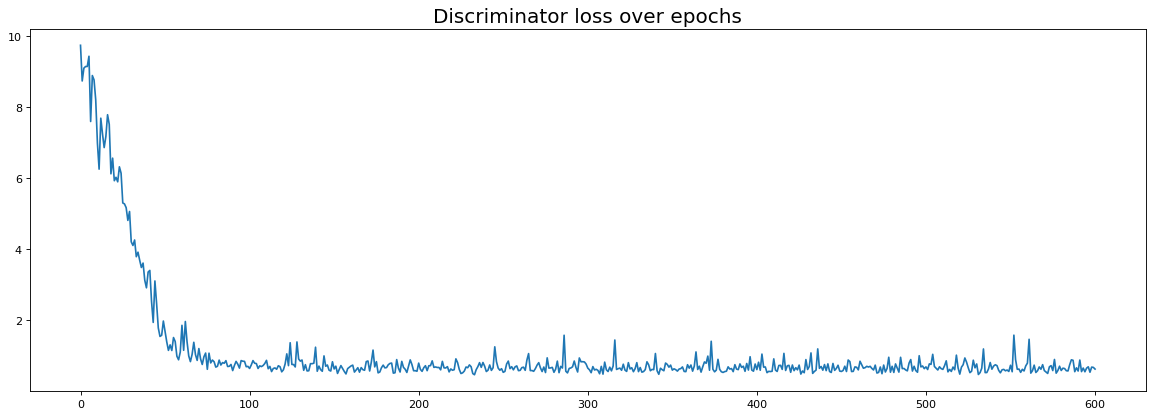

In [69]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(18, 6), dpi=80)
plt.title('Discriminator loss over epochs',fontsize=18)

plt.plot(history['d_loss'],label='Discriminator loss')
#plt.plot(d_loss_smooth,label='Discriminator loss')
#plt.legend_show()
#plt.show()


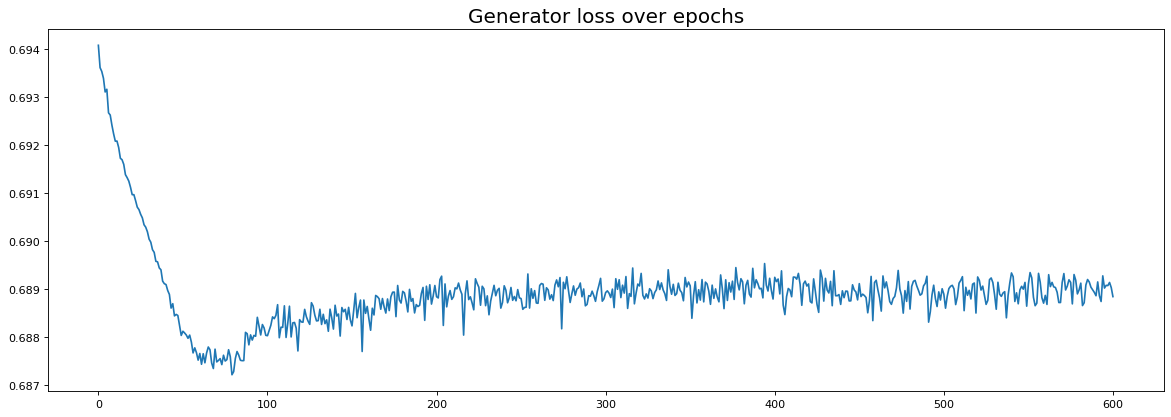

In [70]:
figure(figsize=(18, 6), dpi=80)
plt.title('Generator loss over epochs',fontsize=18)

plt.plot(history['g_loss'],label='Generator loss')

# Generator Model

In [71]:
#Given input of noise (latent) vector, the Generator produces an sample.
def generator2():

    noise_shape = (8,) #1D array of size 100 (latent vector / noise)

#Define your generator network 
#Here we are only using Dense layers. But network can be complicated based
#on the application. For example, you can use VGG for super res. GAN.         

    model2 = Sequential()

    model2.add(Dense(diabetes_dim, input_shape=noise_shape))
    model2.add(LeakyReLU(alpha=0.2))
    
    model2.add(Dense(diabetes_dim*0.6))
    model2.add(Dropout(0.1))
    model2.add(BatchNormalization(momentum=0.8))
    model2.add(Dense(diabetes_dim*0.8))
    model2.add(LeakyReLU(alpha=0.2))
    
    
    model2.add(Dense(np.prod(diabetes_dim), activation='tanh'))
    #model.add(Reshape(diabetes_dim))

    #model2.summary()

    noise = Input(shape=noise_shape)
    sample = model2(noise)    #Generated sample
    
    return Model(noise, sample)

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training

generator = generator2()

#Discriminator Model

In [72]:

#Given an input sample, the Discriminator outputs the likelihood of the sample being real.
#Binary classification - true or false (we're calling it validity)

def discriminator2():

    diabetes_dim_shape = (diabetes_dim,)
    model2 = Sequential()

    model2.add(Dense(diabetes_dim, input_shape=diabetes_dim_shape))
    model2.add(Dense(diabetes_dim*2))
    model2.add(Dropout(0.2))
    model2.add(Dense(diabetes_dim*0.5))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(Dense(diabetes_dim*0.2))
    model2.add(LeakyReLU(alpha=0.1))
    model2.add(Dense(1, activation='sigmoid'))
    #model2.summary()

    diabetes_input = Input(shape=diabetes_dim)
    validity = model2(diabetes_input)

    return Model(diabetes_input, validity)
#The validity is the Discriminator’s guess of input being real or not.
discriminator = discriminator2()

#Training flow

In [73]:
#Now that we have constructed our two models it’s time to pit them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#samples and setting the ground truths. 

def train(epochs, batch_size=128, save_interval=50):

    half_batch = int(batch_size / 2)
#We then loop through a number of epochs to train our Discriminator by first selecting
#a random batch of samples from our true dataset, generating a set of samples from our
#Generator, feeding both set of samples into our Discriminator, and finally setting the
#loss parameters for both the real and fake samples, as well as the combined loss. 
    
    for epoch in range(epochs):
      
      if epoch>500 and np.var(d_loss)<5 and np.var(g_loss)<0.5:
            print('break')
            break
      
      # ---------------------
      #  Train Discriminator
      # ---------------------
      
      # Select a random half batch of real samples
      idx = np.random.randint(0, x_train_diabetes.shape[0], half_batch)
      diabetes = x_train_diabetes.iloc[idx]


      noise = np.random.normal(0, 1, (half_batch, 8))

      # Generate a half batch of fake samples
      gen_diabetes = generator.predict(noise)
      
      # Train the discriminator on real and fake samples, separately
      #Research showed that separate training is more effective. 
      d_loss_real = discriminator.train_on_batch(diabetes, np.ones((half_batch, 1)))
      d_loss_fake = discriminator.train_on_batch(gen_diabetes, np.zeros((half_batch, 1)))
    #take average loss from real and fake samples. 

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
      euclidean_distance = distance.euclidean(d_loss_real,d_loss_fake)



      if (euclidean_distance > 1.1):
        print ("real: "+str(d_loss_real)+" , fake: "+str(d_loss_fake) + " , Duclidean distance: "+ str(euclidean_distance))
        print ()
        print("real diabetes values:")
        print(pd.DataFrame(diabetes))
        print("fake diabetes values:")
        print(pd.DataFrame(gen_diabetes))
      
      
      
     
        
      
    #And within the same loop we train our Generator, by setting the input noise and
    #ultimately training the Generator to have the Discriminator label its samples as valid
    #by specifying the gradient loss.
      # ---------------------
      #  Train Generator
      # ---------------------
    #Create noise vectors as input for generator. 
    #Create as many noise vectors as defined by the batch size. 
    #Based on normal distribution. Output will be of size (batch size, 100)
      noise = np.random.normal(0, 1, (batch_size, 8)) 

      # The generator wants the discriminator to label the generated samples
      # as valid (ones)
      #This is where the genrator is trying to trick discriminator into believing
      #the generated sample is true (hence value of 1 for y)
      valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

      # Generator is part of combined where it got directly linked with the discriminator
      # Train the generator with noise as x and 1 as y. 
      # Again, 1 as the output as it is adversarial and if generator did a great
      #job of folling the discriminator then the output would be 1 (true)
      g_loss = gan.train_on_batch(noise, valid_y)
      if (g_loss > 1):
        print("fake diabetes noise values that fooled the model:")
        print(pd.DataFrame(noise))

    #Additionally, in order for us to keep track of our training process, we print the
    #progress and save the sample sample output depending on the epoch interval specified.  
    #Plot the progress
      
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      history['d_loss'].append(d_loss[0])
      history['d_accuracy'].append(d_loss[1])
      history['g_loss'].append(g_loss)
      


In [74]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.
discriminator = discriminator2()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])
history = {'d_loss':[],'d_accuracy':[],'g_loss':[],'g_accuracy':[]}

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (faking) samples, let us not track any metrics.
generator = generator2()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its samples.  
z = Input(shape=(8,))   #Our random input to the generator
test_if_diabete = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the samples generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(test_if_diabete)  #Validity check on the generated sample


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates samples => determines validity


gan = Model(z, valid)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=1000, batch_size=32, save_interval=10)

#Save model for future use to generate fake samples
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample function.

real: [1.9659817218780518, 0.0] , fake: [0.6360897421836853, 0.25] , Duclidean distance: 1.353186120847905

real diabetes values:
            0         1         2  ...         5         6         7
530  0.117647  0.613065  0.491803  ...  0.444113  0.272844  0.016667
106  0.058824  0.482412  1.000000  ...  0.333830  0.055081  0.100000
21   0.470588  0.497487  0.688525  ...  0.527571  0.132365  0.483333
67   0.117647  0.547739  0.754098  ...  0.636364  0.327498  0.550000
509  0.470588  0.603015  0.639344  ...  0.372578  0.141332  0.716667
14   0.294118  0.834171  0.590164  ...  0.384501  0.217336  0.500000
20   0.176471  0.633166  0.721311  ...  0.585693  0.267293  0.100000
380  0.058824  0.537688  0.590164  ...  0.459016  0.317250  0.050000
265  0.294118  0.482412  0.606557  ...  0.500745  0.392400  0.366667
554  0.058824  0.422111  0.524590  ...  0.549925  0.167805  0.116667
363  0.235294  0.733668  0.639344  ...  0.573770  0.188728  0.766667
77   0.294118  0.477387  0.590164  ...  0.

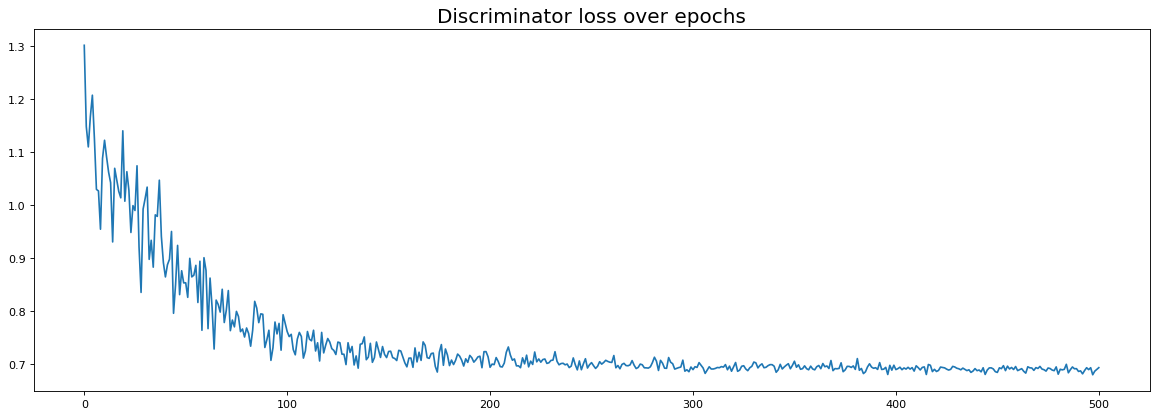

In [75]:
figure(figsize=(18, 6), dpi=80)
plt.title('Discriminator loss over epochs',fontsize=18)

plt.plot(history['d_loss'],label='Discriminator loss')

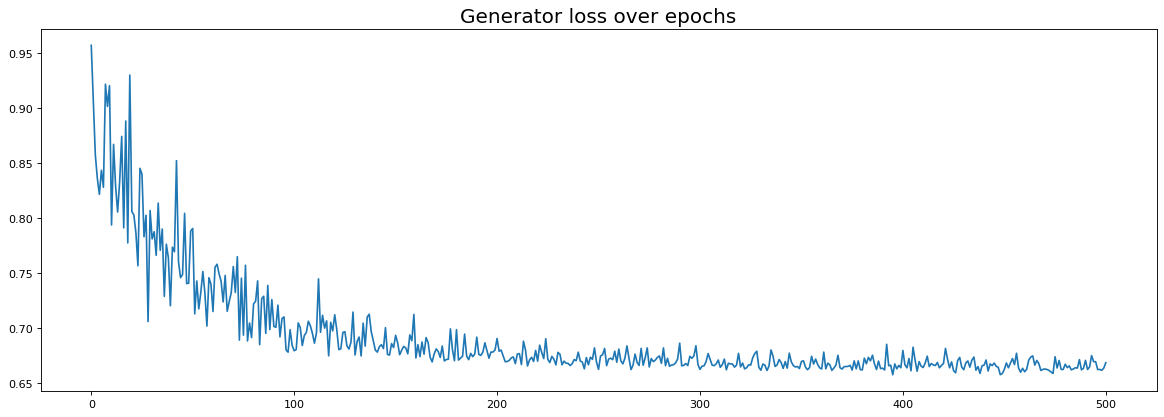

In [76]:
figure(figsize=(18, 6), dpi=80)
plt.title('Generator loss over epochs',fontsize=18)

plt.plot(history['g_loss'],label='Generator loss')

# Random Forest model

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
Xtrain, Xtest, ytrain, ytest = train_test_split(x_train_diabetes, y_train_diabetes,
                                                 test_size=0.33, random_state=42)

def BB_Model(sample_Xtrain,sample_ytrain):
  model = RandomForestClassifier(n_estimators=100, random_state=0)
  
  model = RandomForestClassifier(n_estimators=1000)
  model.fit(Xtrain, ytrain)
  return model

bb_model=BB_Model(Xtrain,ytrain)
ypred = bb_model.predict(Xtest)
accuracy_score(ytest, ypred)

0.7559055118110236

# BUILD new generator

In [78]:
def generator3(sample_shape,batch_size,desired_confidence_shape,output_size):
  
    _input1= Input(shape=sample_shape,batch_size=batch_size)
    vector_input = Input(shape = desired_confidence_shape)
    input = concatenate([_input1,vector_input])
    x = Dense(int(output_size*2), activation='relu')(input)
    x = Dense(int(output_size*1.2), activation='relu')(x)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(int(output_size*0.2), activation='relu')(x)
    x = Dense(int(output_size), activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(output_size)(x)



    model = Model(inputs=[_input1,vector_input], outputs=x)
    return model

def discriminator3(sample_shape,desired_confidence_shape,batch_size):
    data = sample_shape[0]
    model_input1 = Input(shape=sample_shape, batch_size=batch_size)
    model_input2 = Input(shape=desired_confidence_shape)
    input = concatenate([model_input1,model_input2])
    y = Dense(int(data*0.8), activation='relu')(input)
    y = Dropout(0.1)(y)
    y = Dense(int(data), activation='relu')(y)
    y = Dense(int(data*0.3), activation='relu')(y)
    y = Dense(int(data*0.9), activation='relu')(y)
    y = Dropout(0.01)(y)
    y = Dense(int(data*0.2), activation='relu')(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=[model_input1,model_input2], outputs=y)
    return model

def models_3(num_of_features,scalar, batch_size, noise_dim,lr=0.0001):

    generator = generator3((noise_dim,),batch_size,scalar,num_of_features)

    discriminator = discriminator3((num_of_features,),scalar, batch_size)

    optimizer = Adam(lr, 0.5)

    discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    z = Input(shape=(noise_dim,))
    k = Input(shape=(1,))
    x = generator([z,k])

    disc_output = discriminator([x,k])
    #We don't want the disc to be trained on the wrong labels
    discriminator.trainable = False

    gan = Model([z,k], disc_output)
    optimizer = Adam(lr, 0.5)

    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return gan , generator , discriminator

    

In [79]:
# configuration setup
batch = 500
half_batch = int(batch / 2)

epochs = 5000
interval = 100
df_train = df_germancredit
target = '21'
noise=np.random.normal(0, 1, (half_batch, 8))

batch_size=32
scalar = np.random.uniform(0, 1,(batch_size,1))
#ypred = bb_model.predict(Xtest)

# train
gan , generator , discriminator = models_3(x_train_diabetes.shape[1],scalar.shape[1],batch_size,noise.shape[1],2e-4)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))
history = {'d_loss':[],'d_accuracy':[],'g_loss':[],'g_accuracy':[]}

for epoch in range(epochs):    
    
    if epoch%100==0 and epoch!=0:
        lr = K.get_value(discriminator.optimizer.lr)/10
        K.set_value(discriminator.optimizer.learning_rate, lr)
        K.set_value(gan.optimizer.learning_rate, lr)
        print(K.get_value(discriminator.optimizer.lr),K.get_value(gan.optimizer.lr))


    # train discriminator
    
    real_data = get_real_data(x_train_diabetes, batch_size)
    noise = tf_random.normal((batch_size, noise.shape[1]))
    fake_data = generator.predict([noise,scalar])
    #d_data = np.vstack((real_data, fake_data))
    d_data = np.vstack((noise, fake_data))
    real_labels = bb_model.predict(pd.DataFrame(noise.numpy())).reshape(batch_size,1)
    
    d_labels = np.vstack((real_labels, fake_labels))
    new_scalar=np.vstack((scalar, scalar))
    d_data=np.asarray(d_data).astype('float32')
    new_scalar=np.asarray(new_scalar).astype('float32')
    d_labels=np.asarray(d_labels).astype('float32')
    real_labels = np.asarray(real_labels).astype('float32')
    d_results = discriminator.train_on_batch([d_data,new_scalar] ,d_labels)
    # train generator
    #noise = tf_random.normal((batch_size, noise.shape[1]))
    g_results = gan.train_on_batch([noise, scalar],real_labels)
    
    history['d_loss'].append(d_results[0])
    history['d_accuracy'].append(d_results[1])
    history['g_loss'].append(g_results[0])
    history['g_accuracy'].append(g_results[1])
    if epoch%(interval)==0 and epoch!=0:
        print("epoch: "+str(epoch))
        print("d_loss: "+str(d_results[0])+" d_accuracy: "+str(d_results[1]))
        print("g_loss: "+str(g_results[0])+" g_accuracy: "+str(g_results[1]))
        last_d_loss = history['d_loss'][-100:] 
        last_g_loss = history['g_loss'][-100:] 
        print(np.var(last_d_loss),np.var(last_g_loss))

        if epoch>500 and np.var(last_d_loss)<5 and np.var(last_g_loss)<0.01:
            print('break')
            break
    if (epoch+1) % interval == 0:
        real_data = get_real_data(x_train_diabetes, batch_size)
        print('Discriminator Evaluation Real:')
        d_results_real = discriminator.evaluate([real_data,scalar], real_labels)
        #noise = tf_random.normal((batch_size, noise.shape[1]))
        fake_data = generator.predict([noise,scalar])
        print('Discriminator Evaluation Fake:')
        d_results_fake = discriminator.evaluate([fake_data,scalar], fake_labels)
        # TODO: save result data persist???? - fake_data to save
        # TODO: save the model??? checkpoint


Discriminator Evaluation Real:
1/1 [==============================] - 0s 142ms/step - loss: 0.6882 - accuracy: 0.7500
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 19ms/step - loss: 0.6833 - accuracy: 1.0000
2e-05 2e-05
epoch: 100
d_loss: 0.6853513717651367 d_accuracy: 0.8958333134651184
g_loss: 0.6894769072532654 g_accuracy: 0.6875
5.047003968483921e-06 2.972276234389425e-06
Discriminator Evaluation Real:
1/1 [==============================] - 0s 18ms/step - loss: 0.6878 - accuracy: 0.7500
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 19ms/step - loss: 0.6823 - accuracy: 1.0000
2e-06 2e-06
epoch: 200
d_loss: 0.6845836043357849 d_accuracy: 0.8958333134651184
g_loss: 0.6891216039657593 g_accuracy: 0.6875
5.367289015097753e-07 2.029704412639077e-06
Discriminator Evaluation Real:
1/1 [==============================] - 0s 19ms/step - loss: 0.6877 - accuracy: 0.7500
Discriminator Evaluation Fake:
1/1 [==============================] - 0s

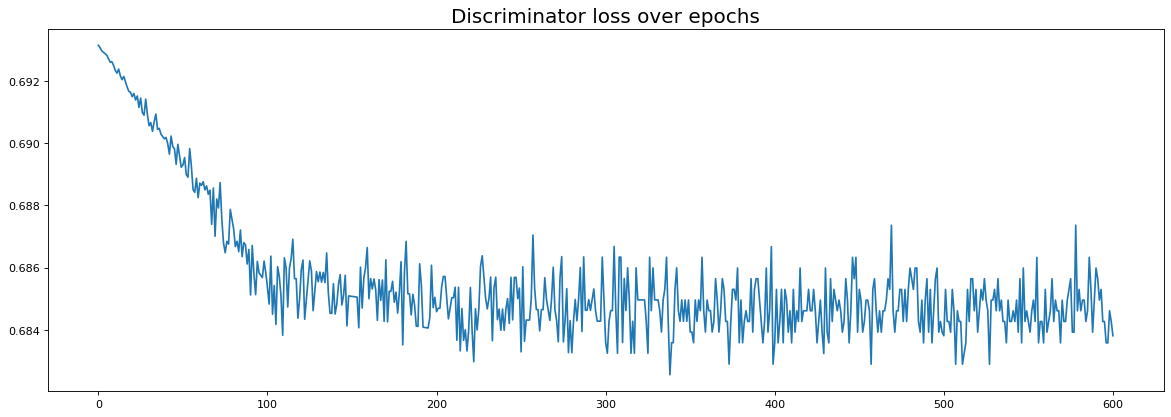

In [80]:

figure(figsize=(18, 6), dpi=80)
plt.title('Discriminator loss over epochs',fontsize=18)

plt.plot(history['d_loss'],label='Discriminator loss')
#plt.plot(d_loss_smooth,label='Discriminator loss')
#plt.legend_show()
#plt.show()


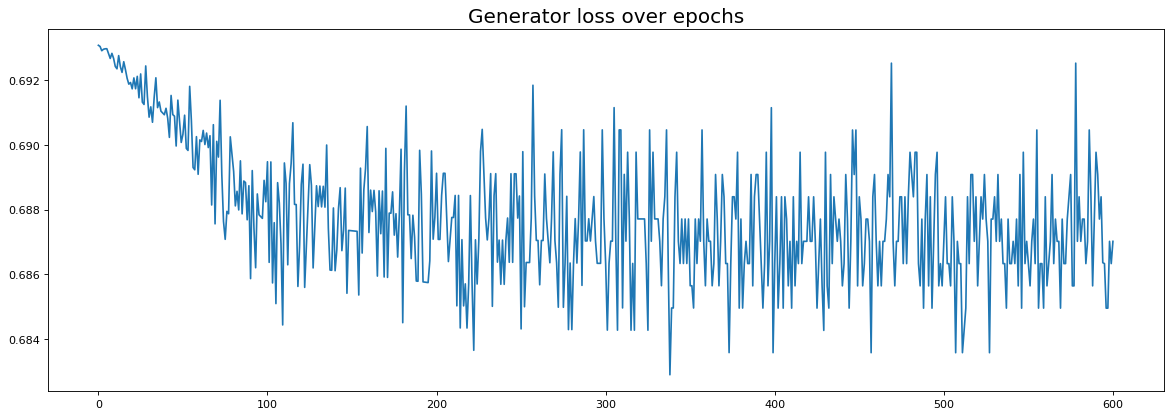

In [81]:
figure(figsize=(18, 6), dpi=80)
plt.title('Generator loss over epochs',fontsize=18)

plt.plot(history['g_loss'],label='Generator loss')

#Germancredit Dataset - GAN

In [82]:
x_train_germancredit=df_germancredit.iloc[: , :-1].astype('int32')
x_train_germancredit=min_max_scaler.fit_transform(x_train_germancredit)

Xtrain, Xtest, ytrain, ytest = train_test_split(x_train_germancredit, y_train_germancredit,
                                                 test_size=0.33, random_state=42)


def BB_Model(sample_Xtrain,sample_ytrain):
  model = RandomForestClassifier(n_estimators=100, random_state=0)
  
  model = RandomForestClassifier(n_estimators=1000)
  model.fit(Xtrain, ytrain)
  return model


bb_model=BB_Model(Xtrain, ytrain)
ypred = bb_model.predict(Xtest)
accuracy_score(ytest, ypred)


0.7696969696969697

In [83]:
def generator4(sample_shape,batch_size,desired_confidence_shape,output_size):
  
    _input1= Input(shape=sample_shape,batch_size=batch_size)
    vector_input = Input(shape = desired_confidence_shape)
    input = concatenate([_input1,vector_input])
    x = Dense(int(output_size*2), activation='relu')(input)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(int(output_size*0.3), activation='relu')(x)
    x = Dense(int(output_size*0.1), activation='relu')(x)
    x = Dense(int(output_size), activation='relu')(x)
    x = Dropout(0.05)(x)
    x = Dense(int(output_size*0.8), activation='relu')(x)
    x = Dense(output_size)(x)



    model = Model(inputs=[_input1,vector_input], outputs=x)
    return model

def discriminator4(sample_shape,desired_confidence_shape,batch_size):
    data = sample_shape[0]
    model_input1 = Input(shape=sample_shape, batch_size=batch_size)
    model_input2 = Input(shape=desired_confidence_shape)
    input = concatenate([model_input1,model_input2])
    y = Dense(int(data*0.9), activation='relu')(input)
    y = Dropout(0.1)(y)
    y = Dense(int(data), activation='relu')(y)
    y = Dense(int(data*0.3), activation='relu')(y)
    y = Dense(int(data*0.4), activation='relu')(y)
    y = Dropout(0.02)(y)
    y = Dense(int(data*0.1), activation='relu')(y)
    y = Dense(1, activation='sigmoid')(y)
    model = Model(inputs=[model_input1,model_input2], outputs=y)
    return model

def models_4(num_of_features,scalar, batch_size, noise_dim,lr=0.0001):

    generator = generator3((noise_dim,),batch_size,scalar,num_of_features)

    discriminator = discriminator3((num_of_features,),scalar, batch_size)

    optimizer = Adam(lr, 0.5)

    discriminator.compile(loss='binary_crossentropy',
                               optimizer=optimizer,
                               metrics=['accuracy'])

    z = Input(shape=(noise_dim,))
    k = Input(shape=(1,))
    x = generator([z,k])

    disc_output = discriminator([x,k])
    #We don't want the disc to be trained on the wrong labels
    discriminator.trainable = False

    gan = Model([z,k], disc_output)
    optimizer = Adam(lr, 0.5)

    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return gan , generator , discriminator

    

In [84]:
history = {'d_loss':[],'d_accuracy':[],'g_loss':[],'g_accuracy':[]}
# configuration setup

batch = 500
half_batch = int(batch / 2)

epochs = 5000
interval = 100
df_train = df_germancredit.iloc[: , :-1]
noise=np.random.normal(0, 1, (half_batch, 20))

batch_size=32
scalar = np.random.uniform(0, 1,(batch_size,1))

#ypred = bb_model.predict(Xtest)

# train
gan , generator , discriminator = models_4(x_train_germancredit.shape[1],scalar.shape[1],batch_size,noise.shape[1],2e-4)
real_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))
history = {'d_loss':[],'d_accuracy':[],'g_loss':[],'g_accuracy':[]}

for epoch in range(epochs):    
    
    if epoch%100==0 and epoch!=0:
        lr = K.get_value(discriminator.optimizer.lr)/10
        K.set_value(discriminator.optimizer.learning_rate, lr)
        K.set_value(gan.optimizer.learning_rate, lr)
        print(K.get_value(discriminator.optimizer.lr),K.get_value(gan.optimizer.lr))


    # train discriminator
    
    real_data = get_real_data(df_train, batch_size)
    noise = tf_random.normal((batch_size, noise.shape[1]))
    fake_data = generator.predict([noise,scalar])
    #d_data = np.vstack((real_data, fake_data))
    d_data = np.vstack((noise, fake_data))
    real_labels = bb_model.predict(pd.DataFrame(noise.numpy())).reshape(batch_size,1)
    
    d_labels = np.vstack((real_labels, fake_labels))
    new_scalar=np.vstack((scalar, scalar))
    d_data=np.asarray(d_data).astype('float32')
    new_scalar=np.asarray(new_scalar).astype('float32')
    d_labels=np.asarray(d_labels).astype('float32')
    real_labels = np.asarray(real_labels).astype('float32')
    d_results = discriminator.train_on_batch([d_data,new_scalar] ,d_labels)
    # train generator
    #noise = tf_random.normal((batch_size, noise.shape[1]))
    g_results = gan.train_on_batch([noise, scalar],real_labels)
    
    history['d_loss'].append(d_results[0])
    history['d_accuracy'].append(d_results[1])
    history['g_loss'].append(g_results[0])
    history['g_accuracy'].append(g_results[1])
    if epoch%(interval)==0 and epoch!=0:
        print("epoch: "+str(epoch))
        print("d_loss: "+str(d_results[0])+" d_accuracy: "+str(d_results[1]))
        print("g_loss: "+str(g_results[0])+" g_accuracy: "+str(g_results[1]))
        last_d_loss = history['d_loss'][-100:] 
        last_g_loss = history['g_loss'][-100:] 
        print(np.var(last_d_loss),np.var(last_g_loss))

        if epoch>500 and np.var(last_d_loss)<5 and np.var(last_g_loss)<0.01:
            print('break')
            break
    if (epoch+1) % interval == 0:
        real_data = get_real_data(df_train, batch_size)
        print('Discriminator Evaluation Real:')
        d_results_real = discriminator.evaluate([real_data,scalar], real_labels)
        #noise = tf_random.normal((batch_size, noise.shape[1]))
        fake_data = generator.predict([noise,scalar])
        print('Discriminator Evaluation Fake:')
        d_results_fake = discriminator.evaluate([fake_data,scalar], fake_labels)
        # TODO: save result data persist???? - fake_data to save
        # TODO: save the model??? checkpoint


Discriminator Evaluation Real:
1/1 [==============================] - 0s 138ms/step - loss: 28.3874 - accuracy: 0.4688
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 19ms/step - loss: 0.6836 - accuracy: 1.0000
2e-05 2e-05
epoch: 100
d_loss: 0.6993991732597351 d_accuracy: 0.7708333134651184
g_loss: 0.6890003085136414 g_accuracy: 0.71875
0.0006416470967909116 1.2247378546526022e-05
Discriminator Evaluation Real:
1/1 [==============================] - 0s 18ms/step - loss: 20.7945 - accuracy: 0.3438
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 18ms/step - loss: 0.6827 - accuracy: 1.0000
2e-06 2e-06
epoch: 200
d_loss: 0.6922970414161682 d_accuracy: 0.84375
g_loss: 0.6932026743888855 g_accuracy: 0.5
0.00017657195483679406 2.811974443373799e-06
Discriminator Evaluation Real:
1/1 [==============================] - 0s 19ms/step - loss: 14.2896 - accuracy: 0.4688
Discriminator Evaluation Fake:
1/1 [==============================] - 0s 27ms/st

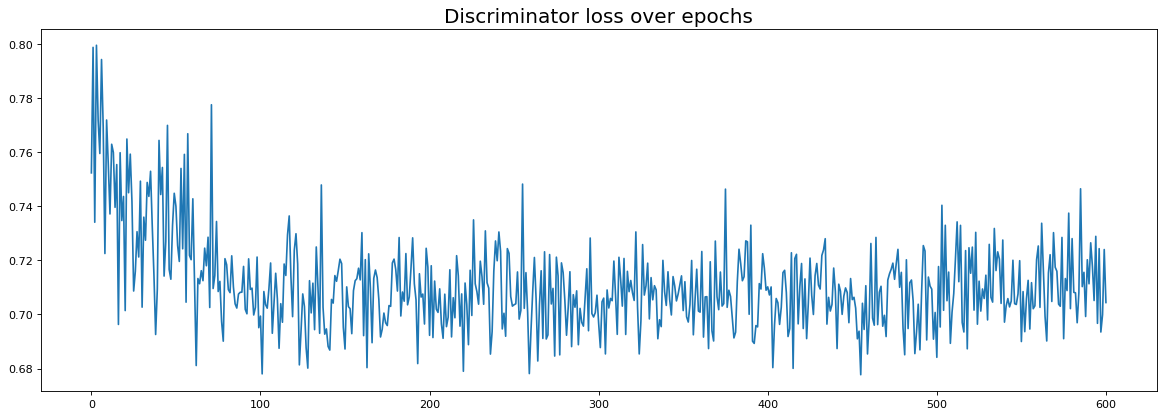

In [85]:

figure(figsize=(18, 6), dpi=80)
plt.title('Discriminator loss over epochs',fontsize=18)

plt.plot(history['d_loss'],label='Discriminator loss')
#plt.plot(d_loss_smooth,label='Discriminator loss')
#plt.legend_show()
#plt.show()


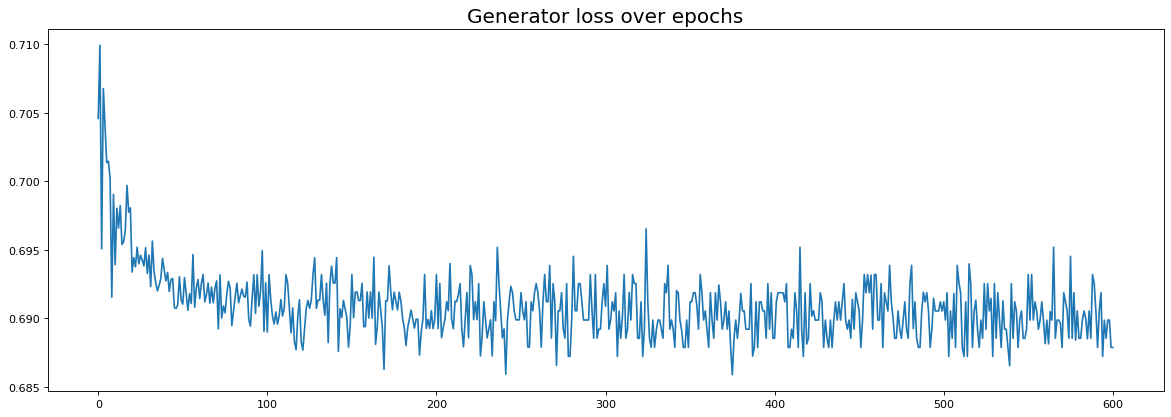

In [86]:
figure(figsize=(18, 6), dpi=80)
plt.title('Generator loss over epochs',fontsize=18)

plt.plot(history['g_loss'],label='Generator loss')